In [1]:
pip install numpy pandas yfinance matplotlib seaborn scikit-learn tensorflow keras statsmodels plotly streamlit


  Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl.metadata (3.3 kB)
  Using cached streamlit-1.42.2-py2.py3-none-any.whl.metadata (8.9 kB)
  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
Using cached tensorflow-2.18.0-cp311-cp311-win_amd64.whl (7.5 kB)
Using cached streamlit-1.42.2-py2.py3-none-any.whl (9.6 MB)
Using cached altair-5.5.0-py3-none-any.whl (731 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import yfinance as yf
import pandas as pd

# Define stock ticker and date range
ticker = "AAPL"  # Change to your preferred stock
start_date = "2015-01-01"
end_date = "2024-01-01"

# Fetch data
df = yf.download(ticker, start=start_date, end=end_date)
df.to_csv("stock_data.csv")  # Save as CSV




YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
print(df.head())  # View first few rows

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.320427  24.789796  23.879976  24.778673  212818400
2015-01-05  23.635292  24.169172  23.448435  24.089090  257142000
2015-01-06  23.637514  23.897780  23.274920  23.699800  263188400
2015-01-07  23.968962  24.069063  23.735389  23.846614  160423600
2015-01-08  24.889898  24.947736  24.180283  24.298183  237458000


In [30]:
import pandas as pd

# Read CSV, skipping the first TWO rows (to remove unwanted headers)
df = pd.read_csv("stock_data.csv", skiprows=2)

# Rename columns (adjust based on actual headers)
df.columns = ["Date", "Open", "High", "Low", "Close", "Volume"]

# Convert 'Date' to datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)

# Convert numeric columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].apply(pd.to_numeric, errors='coerce')

# Drop any NaN values
df.dropna(inplace=True)

# Print cleaned data
print(df.head())
print(df.dtypes)


                 Open       High        Low      Close     Volume
Date                                                             
2015-01-02  24.320427  24.789796  23.879976  24.778673  212818400
2015-01-05  23.635292  24.169172  23.448435  24.089090  257142000
2015-01-06  23.637514  23.897780  23.274920  23.699800  263188400
2015-01-07  23.968962  24.069063  23.735389  23.846614  160423600
2015-01-08  24.889898  24.947736  24.180283  24.298183  237458000
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


In [39]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)


In [40]:
import numpy as np

# Define training size (80% for training, 20% for testing)
train_size = int(len(df_scaled) * 0.8)

# Split into train and test sets
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

print(f"Training Data Shape: {train_data.shape}")
print(f"Testing Data Shape: {test_data.shape}")


Training Data Shape: (1811, 5)
Testing Data Shape: (453, 5)


In [41]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])  # Last 60 days
        y.append(data[i, 0])  # Next day
    return np.array(X), np.array(y)

# Create training sequences
time_steps = 60
X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Training Sequences: {X_train.shape}")
print(f"Testing Sequences: {X_test.shape}")


Training Sequences: (1751, 60, 1)
Testing Sequences: (393, 60, 1)


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - loss: 0.0364 - val_loss: 0.0015
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0011 - val_loss: 0.0055
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 9/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 100ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 10/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 9.6096e-04 - val_loss: 0.0017
Epoch 11/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 12/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms

In [55]:
print("Predictions Shape:", predictions.shape)  


Predictions Shape: (393, 1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


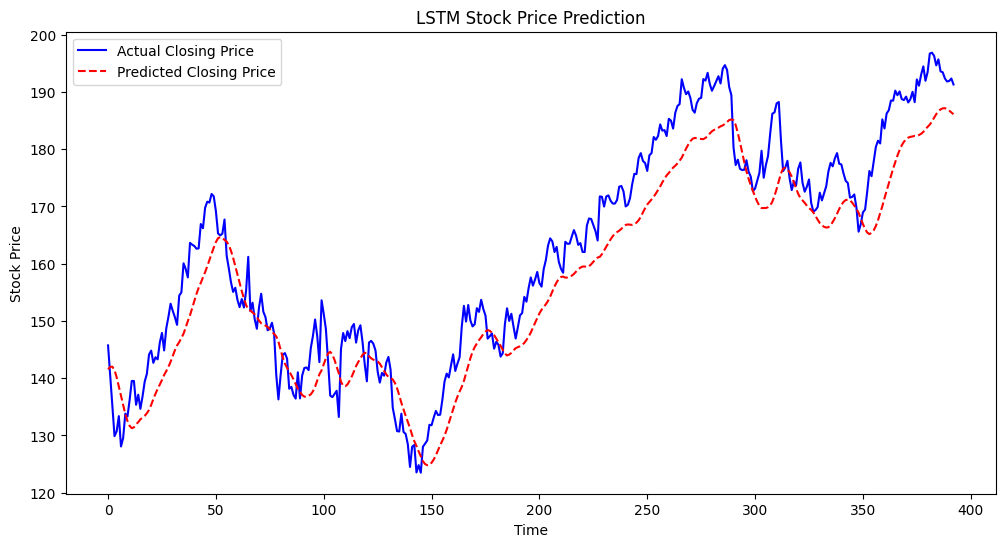

In [59]:
# Predict on test data
predictions = model.predict(X_test)

# Ensure correct shape
predictions = predictions.reshape(-1, 1)

# Ensure scaler was fitted correctly
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df[['Close']])  # Fit only on Close prices

# Check NaN values before inverse transform
predictions = np.nan_to_num(predictions)

# Rescale back to original price
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="Actual Closing Price", color="blue")
plt.plot(predictions_rescaled, label="Predicted Closing Price", color="red", linestyle="dashed")
plt.legend()
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()


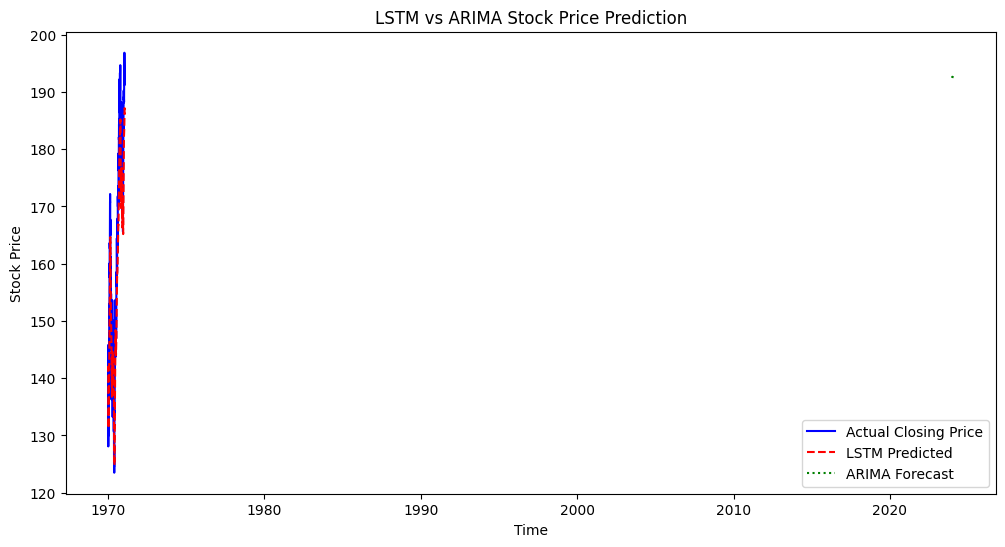

In [60]:
plt.figure(figsize=(12,6))
plt.plot(y_test_rescaled, label="Actual Closing Price", color="blue")
plt.plot(predictions_rescaled, label="LSTM Predicted", color="red", linestyle="dashed")
plt.plot(pd.date_range(start=df.index[-1], periods=30, freq='D'), forecast, label="ARIMA Forecast", linestyle="dotted", color="green")
plt.legend()
plt.title("LSTM vs ARIMA Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.show()
